In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('merge_quant_qual.txt')

In [3]:
df.columns

Index(['datetime', 'reddit_op', 'news_op', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'SMA', 'EMA', 'macd', 'macd_h', 'macd_s', 'diff',
       'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi', 'OBV', 'n_high',
       'n_low', '%K', '%D', 'dolar', 'Dolar', 'IGP-M', 'IPC-Br', 'IPA', 'IPCA',
       'INPC', 'Selic', 'CDI', 'Produção - Óleo Bruto', 'Produção - LGN',
       'Producao - Total', 'Produção - Gas natural', 'Consumo - Gasolina',
       'Consumo - GLP', 'Consumo - Óleo combustivel', 'Consumo - Oleo diesel',
       'Consumo - Demais derivados', 'Consumo - Total de derivados',
       'PETR3: (Brazil)', 'PETR4: (Brazil)', 'Petrobras: (Brazil)',
       'Petróleo: (Brazil)', 'oil_price', 'bova'],
      dtype='object')

In [4]:
# target do modelo
df['dC'] = df['Adj Close'].diff(-1)*(-1)
df['target'] = df['dC'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
features = ['reddit_op', 'news_op',
    'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close',
            'SMA', 'EMA', 'macd', 'macd_h', 'macd_s',
           'rsi', 'OBV', '%K', '%D', 'dolar', 'IGP-M', 'IPC-Br', 'IPA', 'IPCA', 'INPC', 'CDI',
           'Produção - Óleo Bruto', 'Produção - LGN', 'Producao - Total',
           'Produção - Gas natural', 'Consumo - Gasolina', 'Consumo - GLP',
           'Consumo - Óleo combustivel', 'Consumo - Oleo diesel',
           'Consumo - Demais derivados', 'Consumo - Total de derivados', 'bova',
           'PETR3: (Brazil)', 'PETR4: (Brazil)', 'Petrobras: (Brazil)', 'Petróleo: (Brazil)', 'oil_price']

X = df.loc[:, features]
y = df['target'].astype('category')

# Importancia de features utilizando logistic regression

In [6]:
X_train, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test2, y_test)

0.5625

In [7]:
# predições do modelo lr
lr_preds = pipe.predict(X_test2)

In [8]:
# acurácia do modelo lr
accuracy_lr = accuracy_score(y_test, lr_preds)
print('Accuracy do modelo logistic regression: ', accuracy_lr)

Accuracy do modelo logistic regression:  0.5625


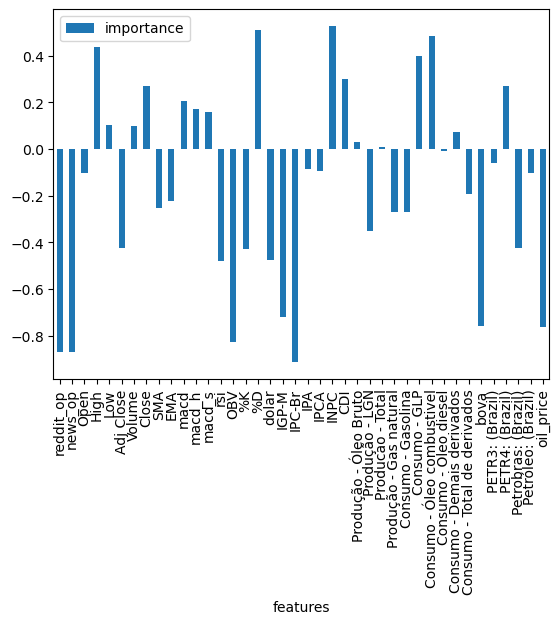

In [9]:
importance = pipe.steps[1][1].coef_[0]
feat_imp = pd.DataFrame({'features': X_train.columns, 'importance': importance})
feat_imp.plot.bar(x='features', y='importance', rot=90);
pyplot.show()

# Filtrado das features

In [10]:
feat_imp
good_feat = feat_imp[~feat_imp['importance'].between(-.20, .20)].features

In [11]:
# aqui fazemos novamente o dataframe apenas com as features filtradas
X = df.loc[:, good_feat]
y = df['Adj Close'].diff(-10)*(-1)

# modelo LSTM

In [12]:
def transform_scale(dataset):
    
    values = dataset.values
#     # integer encode direction
#     encoder = LabelEncoder()
#     values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
#     reframed = series_to_supervised(scaled, 1, 1)
    return scaled

def norm_targets(targets):
    targets = targets.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(targets)
    return targets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [14]:
X_test.columns

Index(['reddit_op', 'news_op', 'High', 'Adj Close', 'Close', 'SMA', 'EMA',
       'macd', 'rsi', 'OBV', '%K', '%D', 'dolar', 'IGP-M', 'IPC-Br', 'INPC',
       'CDI', 'Produção - LGN', 'Produção - Gas natural', 'Consumo - Gasolina',
       'Consumo - GLP', 'Consumo - Óleo combustivel', 'bova',
       'PETR4: (Brazil)', 'Petrobras: (Brazil)', 'oil_price'],
      dtype='object')

In [15]:
X_test3 = X_test.copy()

In [16]:
# df.loc[244:,['Open']]

In [17]:
# fazemos um csv para incluir no backtesting como entrada
X_test3['Open'] = df.loc[244:,['Open']]
X_test3['High'] = df.loc[244:,['High']]
# X_test3['Low'] = X_test2['Low']
# X_test3['High'] = X_test2['High']

In [18]:
X_test3.columns

Index(['reddit_op', 'news_op', 'High', 'Adj Close', 'Close', 'SMA', 'EMA',
       'macd', 'rsi', 'OBV', '%K', '%D', 'dolar', 'IGP-M', 'IPC-Br', 'INPC',
       'CDI', 'Produção - LGN', 'Produção - Gas natural', 'Consumo - Gasolina',
       'Consumo - GLP', 'Consumo - Óleo combustivel', 'bova',
       'PETR4: (Brazil)', 'Petrobras: (Brazil)', 'oil_price', 'Open'],
      dtype='object')

In [19]:
# passamos para csv
X_test3.to_csv('X_test3.csv')

In [20]:
X_test3

,reddit_op,news_op,High,Adj Close,Close,SMA,EMA,macd,rsi,OBV,...,Produção - LGN,Produção - Gas natural,Consumo - Gasolina,Consumo - GLP,Consumo - Óleo combustivel,bova,PETR4: (Brazil),Petrobras: (Brazil),oil_price,Open
244,0.520032,0.520032,26.879999,16.420815,26.680000,16.336700,16.38,-0.124881,45.445158,805899800.0,...,86.0,0.839,0.839,232.0,84.0,116181.0,36.0,32.0,70.459999,26.549999
245,0.520012,0.520012,27.299999,16.599300,26.969999,16.521341,16.49,-0.116236,48.252552,818328500.0,...,86.0,0.839,0.839,232.0,84.0,115063.0,36.0,29.0,72.610001,26.750000
246,0.519991,0.519991,26.940001,16.445433,26.719999,16.488516,16.47,-0.120413,46.122518,808346100.0,...,86.0,0.839,0.839,232.0,84.0,113794.0,34.0,26.0,72.610001,26.870001
247,0.519970,0.519970,26.700001,15.694556,25.500000,16.246430,16.08,-0.182212,37.264836,776623000.0,...,86.0,0.839,0.839,232.0,84.0,111439.0,35.0,28.0,71.970001,26.610001
248,0.519949,0.519949,25.240000,15.528379,25.230000,15.889456,15.80,-0.241810,35.596121,756524300.0,...,86.0,0.839,0.839,232.0,84.0,108844.0,41.0,28.0,70.290001,24.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.518924,0.518924,30.500000,20.830538,30.219999,20.853516,20.92,0.814470,59.598016,920027600.0,...,97.0,0.832,0.832,227.0,42.0,105244.0,25.0,35.0,72.760002,30.360001
301,0.518905,0.518905,30.680000,20.982185,30.440001,20.908660,20.95,0.760520,61.012051,926271100.0,...,97.0,0.832,0.832,227.0,42.0,104891.0,30.0,35.0,73.790001,30.350000
302,0.518887,0.518887,31.469999,21.409550,31.059999,21.262499,21.29,0.721157,64.740056,952217200.0,...,97.0,0.832,0.832,227.0,42.0,104864.0,33.0,38.0,75.980003,31.260000
303,0.518868,0.518868,31.340000,21.333729,30.950001,21.379681,21.31,0.690107,63.403236,940756250.0,...,97.0,0.832,0.832,227.0,42.0,104107.0,32.0,35.0,76.559998,31.010000


In [21]:
# normalize features
X_train = transform_scale(X_train)
X_test = transform_scale(X_test)

In [22]:
y_train = norm_targets(np.array(y_train).reshape(1, -1))
y_test = norm_targets(np.array(y_test).reshape(1, -1))

C:\Users\Ernesto\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Ernesto\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [23]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [24]:
def get_early_stopping():
    '''
    Early stopping para o treinamento do modelo quando a performance não aumenta
    '''
    callback = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=2000,
                    verbose=0,
                    )
    return callback

# the checkpoint functionality saves the model with best performance
def get_checkpoint_best_only():
    '''
    this function includes the checkpoint functionality to the model and training process
    '''
    checkpoint_path='checkpoints_best_only/checkpoint'
    checkpoint= ModelCheckpoint(filepath=checkpoint_path,
                               frequency='epoch',
                               save_weights_only=True,
                               monitor='loss',
                                save_best_only=True,
                               verbose=1)
    return checkpoint

callbacks = [get_checkpoint_best_only(), get_early_stopping()]

# create the model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(100, activation='relu'))
model.add(Flatten(name='flatten_2'),)
model.add(Dense(50, activation='relu'))
model.add(Flatten(name='flatten_3'),)
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               50800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 flatten_2 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [25]:
model.fit(X_train, y_train[0], validation_data=(X_test, y_test[0]), epochs=1000, 
          batch_size=128, callbacks=callbacks)

Epoch 1/1000
1/2 [==============>...............] - ETA: 2s - loss: 1.6599 - mse: 1.6599
Epoch 1: loss improved from inf to 1.57557, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 3s 824ms/step - loss: 1.5756 - mse: 1.5756 - val_loss: nan - val_mse: nan
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.6124 - mse: 1.6124
Epoch 2: loss improved from 1.57557 to 1.54349, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 203ms/step - loss: 1.5435 - mse: 1.5435 - val_loss: nan - val_mse: nan
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.5365 - mse: 1.5365
Epoch 3: loss improved from 1.54349 to 1.51618, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 199ms/step - loss: 1.5162 - mse: 1.5162 - val_loss: nan - val_mse: nan
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.3406 - mse: 1.3406
Epoch 4: loss impr

1/2 [==============>...............] - ETA: 0s - loss: 0.2641 - mse: 0.2641
Epoch 28: loss improved from 0.30564 to 0.28777, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 225ms/step - loss: 0.2878 - mse: 0.2878 - val_loss: nan - val_mse: nan
Epoch 29/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.2693 - mse: 0.2693
Epoch 29: loss improved from 0.28777 to 0.27256, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 215ms/step - loss: 0.2726 - mse: 0.2726 - val_loss: nan - val_mse: nan
Epoch 30/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.2740 - mse: 0.2740
Epoch 30: loss improved from 0.27256 to 0.26466, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 205ms/step - loss: 0.2647 - mse: 0.2647 - val_loss: nan - val_mse: nan
Epoch 31/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.2531 - mse: 0.2531
Epoch 31: loss improv

2/2 [==============================] - 0s 198ms/step - loss: 0.1436 - mse: 0.1436 - val_loss: nan - val_mse: nan
Epoch 56/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1363 - mse: 0.1363
Epoch 56: loss improved from 0.14359 to 0.14078, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 194ms/step - loss: 0.1408 - mse: 0.1408 - val_loss: nan - val_mse: nan
Epoch 57/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1204 - mse: 0.1204
Epoch 57: loss improved from 0.14078 to 0.13841, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 186ms/step - loss: 0.1384 - mse: 0.1384 - val_loss: nan - val_mse: nan
Epoch 58/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1200 - mse: 0.1200
Epoch 58: loss improved from 0.13841 to 0.13414, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 191ms/step - loss: 0.1341 - mse: 0.1341 - val_loss: nan

Epoch 85/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0954 - mse: 0.0954
Epoch 85: loss improved from 0.09519 to 0.09399, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 254ms/step - loss: 0.0940 - mse: 0.0940 - val_loss: nan - val_mse: nan
Epoch 86/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0749 - mse: 0.0749
Epoch 86: loss improved from 0.09399 to 0.09382, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 254ms/step - loss: 0.0938 - mse: 0.0938 - val_loss: nan - val_mse: nan
Epoch 87/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1012 - mse: 0.1012
Epoch 87: loss did not improve from 0.09382
2/2 [==============================] - 0s 31ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: nan - val_mse: nan
Epoch 88/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1201 - mse: 0.1201
Epoch 88: loss improved from 0.09382 to 0.09238, saving model 

Epoch 115/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0699 - mse: 0.0699
Epoch 115: loss improved from 0.07933 to 0.07920, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 227ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: nan - val_mse: nan
Epoch 116/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0838 - mse: 0.0838
Epoch 116: loss improved from 0.07920 to 0.07872, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 225ms/step - loss: 0.0787 - mse: 0.0787 - val_loss: nan - val_mse: nan
Epoch 117/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0754 - mse: 0.0754
Epoch 117: loss did not improve from 0.07872
2/2 [==============================] - 0s 36ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: nan - val_mse: nan
Epoch 118/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0784 - mse: 0.0784
Epoch 118: loss did not improve from 0.07872
2/2 [=====

1/2 [==============>...............] - ETA: 0s - loss: 0.0543 - mse: 0.0543
Epoch 145: loss improved from 0.06811 to 0.06753, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 364ms/step - loss: 0.0675 - mse: 0.0675 - val_loss: nan - val_mse: nan
Epoch 146/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0743 - mse: 0.0743
Epoch 146: loss did not improve from 0.06753
2/2 [==============================] - 0s 34ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: nan - val_mse: nan
Epoch 147/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0661 - mse: 0.0661
Epoch 147: loss improved from 0.06753 to 0.06661, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 341ms/step - loss: 0.0666 - mse: 0.0666 - val_loss: nan - val_mse: nan
Epoch 148/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0586 - mse: 0.0586
Epoch 148: loss did not improve from 0.06661
2/2 [====================

Epoch 176/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0626 - mse: 0.0626
Epoch 176: loss did not improve from 0.05838
2/2 [==============================] - 0s 34ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: nan - val_mse: nan
Epoch 177/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0564 - mse: 0.0564
Epoch 177: loss did not improve from 0.05838
2/2 [==============================] - 0s 37ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: nan - val_mse: nan
Epoch 178/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0662 - mse: 0.0662
Epoch 178: loss improved from 0.05838 to 0.05770, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 246ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: nan - val_mse: nan
Epoch 179/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0628 - mse: 0.0628
Epoch 179: loss did not improve from 0.05770
2/2 [==============================] - 0s 31ms/step - loss: 0.057

Epoch 207/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0504 - mse: 0.0504
Epoch 207: loss did not improve from 0.05254
2/2 [==============================] - 0s 32ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: nan - val_mse: nan
Epoch 208/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0620 - mse: 0.0620
Epoch 208: loss did not improve from 0.05254
2/2 [==============================] - 0s 31ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: nan - val_mse: nan
Epoch 209/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0492 - mse: 0.0492
Epoch 209: loss improved from 0.05254 to 0.05029, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 226ms/step - loss: 0.0503 - mse: 0.0503 - val_loss: nan - val_mse: nan
Epoch 210/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0507 - mse: 0.0507
Epoch 210: loss improved from 0.05029 to 0.05016, saving model to checkpoints_best_only\checkpoint
2/2 [======

Epoch 238/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0367 - mse: 0.0367
Epoch 238: loss improved from 0.04470 to 0.04364, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 220ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: nan - val_mse: nan
Epoch 239/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0404 - mse: 0.0404
Epoch 239: loss improved from 0.04364 to 0.04272, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 289ms/step - loss: 0.0427 - mse: 0.0427 - val_loss: nan - val_mse: nan
Epoch 240/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0422 - mse: 0.0422
Epoch 240: loss did not improve from 0.04272
2/2 [==============================] - 0s 35ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: nan - val_mse: nan
Epoch 241/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0370 - mse: 0.0370
Epoch 241: loss did not improve from 0.04272
2/2 [=====

Epoch 270/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0337 - mse: 0.0337
Epoch 270: loss improved from 0.04124 to 0.04100, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 208ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: nan - val_mse: nan
Epoch 271/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0470 - mse: 0.0470
Epoch 271: loss did not improve from 0.04100
2/2 [==============================] - 0s 29ms/step - loss: 0.0505 - mse: 0.0505 - val_loss: nan - val_mse: nan
Epoch 272/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0409 - mse: 0.0409
Epoch 272: loss did not improve from 0.04100
2/2 [==============================] - 0s 29ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: nan - val_mse: nan
Epoch 273/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0506 - mse: 0.0506
Epoch 273: loss did not improve from 0.04100
2/2 [==============================] - 0s 29ms/step - loss: 0.043

Epoch 301/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0359 - mse: 0.0359
Epoch 301: loss did not improve from 0.03317
2/2 [==============================] - 0s 30ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: nan - val_mse: nan
Epoch 302/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0340 - mse: 0.0340
Epoch 302: loss did not improve from 0.03317
2/2 [==============================] - 0s 30ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: nan - val_mse: nan
Epoch 303/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0342 - mse: 0.0342
Epoch 303: loss improved from 0.03317 to 0.03303, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 205ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: nan - val_mse: nan
Epoch 304/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0355 - mse: 0.0355
Epoch 304: loss did not improve from 0.03303
2/2 [==============================] - 0s 29ms/step - loss: 0.033

Epoch 332/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0277 - mse: 0.0277
Epoch 332: loss improved from 0.02918 to 0.02881, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 179ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: nan - val_mse: nan
Epoch 333/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0300 - mse: 0.0300
Epoch 333: loss did not improve from 0.02881
2/2 [==============================] - 0s 29ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: nan - val_mse: nan
Epoch 334/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0310 - mse: 0.0310
Epoch 334: loss did not improve from 0.02881
2/2 [==============================] - 0s 29ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: nan - val_mse: nan
Epoch 335/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0236 - mse: 0.0236
Epoch 335: loss improved from 0.02881 to 0.02833, saving model to checkpoints_best_only\checkpoint
2/2 [======

2/2 [==============================] - 0s 29ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: nan - val_mse: nan
Epoch 363/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0303 - mse: 0.0303
Epoch 363: loss did not improve from 0.02585
2/2 [==============================] - 0s 29ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: nan - val_mse: nan
Epoch 364/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0252 - mse: 0.0252
Epoch 364: loss did not improve from 0.02585
2/2 [==============================] - 0s 28ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: nan - val_mse: nan
Epoch 365/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0283 - mse: 0.0283
Epoch 365: loss did not improve from 0.02585
2/2 [==============================] - 0s 29ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: nan - val_mse: nan
Epoch 366/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0241 - mse: 0.0241
Epoch 366: loss did not improve from 0.02585
2/2 [===

Epoch 393/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0210 - mse: 0.0210
Epoch 393: loss did not improve from 0.02149
2/2 [==============================] - 0s 28ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: nan - val_mse: nan
Epoch 394/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0210 - mse: 0.0210
Epoch 394: loss did not improve from 0.02149
2/2 [==============================] - 0s 27ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: nan - val_mse: nan
Epoch 395/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0234 - mse: 0.0234
Epoch 395: loss did not improve from 0.02149
2/2 [==============================] - 0s 28ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: nan - val_mse: nan
Epoch 396/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0204 - mse: 0.0204
Epoch 396: loss did not improve from 0.02149
2/2 [==============================] - 0s 30ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: nan - val_mse: nan
Epoch 39

Epoch 425/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0173 - mse: 0.0173
Epoch 425: loss did not improve from 0.01948
2/2 [==============================] - 0s 29ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: nan - val_mse: nan
Epoch 426/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0229 - mse: 0.0229
Epoch 426: loss did not improve from 0.01948
2/2 [==============================] - 0s 28ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: nan - val_mse: nan
Epoch 427/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0214 - mse: 0.0214
Epoch 427: loss did not improve from 0.01948
2/2 [==============================] - 0s 29ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: nan - val_mse: nan
Epoch 428/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0228 - mse: 0.0228
Epoch 428: loss did not improve from 0.01948
2/2 [==============================] - 0s 29ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: nan - val_mse: nan
Epoch 42

Epoch 457/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0167 - mse: 0.0167
Epoch 457: loss did not improve from 0.01757
2/2 [==============================] - 0s 29ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: nan - val_mse: nan
Epoch 458/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0181 - mse: 0.0181
Epoch 458: loss improved from 0.01757 to 0.01716, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 188ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: nan - val_mse: nan
Epoch 459/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0182 - mse: 0.0182
Epoch 459: loss did not improve from 0.01716
2/2 [==============================] - 0s 30ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: nan - val_mse: nan
Epoch 460/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0168 - mse: 0.0168
Epoch 460: loss did not improve from 0.01716
2/2 [==============================] - 0s 29ms/step - loss: 0.018

Epoch 489/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0237 - mse: 0.0237
Epoch 489: loss did not improve from 0.01549
2/2 [==============================] - 0s 30ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: nan - val_mse: nan
Epoch 490/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0178 - mse: 0.0178
Epoch 490: loss did not improve from 0.01549
2/2 [==============================] - 0s 29ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: nan - val_mse: nan
Epoch 491/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0208 - mse: 0.0208
Epoch 491: loss did not improve from 0.01549
2/2 [==============================] - 0s 29ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: nan - val_mse: nan
Epoch 492/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0271 - mse: 0.0271
Epoch 492: loss did not improve from 0.01549
2/2 [==============================] - 0s 28ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: nan - val_mse: nan
Epoch 49

Epoch 521/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0151 - mse: 0.0151
Epoch 521: loss did not improve from 0.01377
2/2 [==============================] - 0s 31ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: nan - val_mse: nan
Epoch 522/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0154 - mse: 0.0154
Epoch 522: loss did not improve from 0.01377
2/2 [==============================] - 0s 29ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: nan - val_mse: nan
Epoch 523/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mse: 0.0134
Epoch 523: loss did not improve from 0.01377
2/2 [==============================] - 0s 29ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: nan - val_mse: nan
Epoch 524/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0127 - mse: 0.0127
Epoch 524: loss did not improve from 0.01377
2/2 [==============================] - 0s 29ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: nan - val_mse: nan
Epoch 52

Epoch 553/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0126 - mse: 0.0126
Epoch 553: loss did not improve from 0.01207
2/2 [==============================] - 0s 33ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: nan - val_mse: nan
Epoch 554/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0113 - mse: 0.0113
Epoch 554: loss did not improve from 0.01207
2/2 [==============================] - 0s 30ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: nan - val_mse: nan
Epoch 555/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0142 - mse: 0.0142
Epoch 555: loss did not improve from 0.01207
2/2 [==============================] - 0s 30ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: nan - val_mse: nan
Epoch 556/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0146 - mse: 0.0146
Epoch 556: loss did not improve from 0.01207
2/2 [==============================] - 0s 36ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: nan - val_mse: nan
Epoch 55

Epoch 586/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0127 - mse: 0.0127
Epoch 586: loss did not improve from 0.01178
2/2 [==============================] - 0s 29ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: nan - val_mse: nan
Epoch 587/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0119 - mse: 0.0119
Epoch 587: loss improved from 0.01178 to 0.01115, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 217ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: nan - val_mse: nan
Epoch 588/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - mse: 0.0117
Epoch 588: loss improved from 0.01115 to 0.01102, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 184ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: nan - val_mse: nan
Epoch 589/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0127 - mse: 0.0127
Epoch 589: loss did not improve from 0.01102
2/2 [=====

Epoch 618/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0104 - mse: 0.0104
Epoch 618: loss did not improve from 0.01001
2/2 [==============================] - 0s 30ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: nan - val_mse: nan
Epoch 619/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 619: loss did not improve from 0.01001
2/2 [==============================] - 0s 30ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: nan - val_mse: nan
Epoch 620/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0084 - mse: 0.0084
Epoch 620: loss improved from 0.01001 to 0.00949, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 200ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: nan - val_mse: nan
Epoch 621/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0108 - mse: 0.0108
Epoch 621: loss did not improve from 0.00949
2/2 [==============================] - 0s 29ms/step - loss: 0.009

Epoch 650/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0096 - mse: 0.0096
Epoch 650: loss improved from 0.00915 to 0.00897, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 198ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: nan - val_mse: nan
Epoch 651/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 651: loss improved from 0.00897 to 0.00886, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 203ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: nan - val_mse: nan
Epoch 652/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mse: 0.0102
Epoch 652: loss improved from 0.00886 to 0.00878, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 193ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: nan - val_mse: nan
Epoch 653/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mse: 0.0091


Epoch 682/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mse: 0.0099
Epoch 682: loss did not improve from 0.00804
2/2 [==============================] - 0s 28ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: nan - val_mse: nan
Epoch 683/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mse: 0.0092
Epoch 683: loss did not improve from 0.00804
2/2 [==============================] - 0s 28ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: nan - val_mse: nan
Epoch 684/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - mse: 0.0098
Epoch 684: loss did not improve from 0.00804
2/2 [==============================] - 0s 29ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: nan - val_mse: nan
Epoch 685/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mse: 0.0102
Epoch 685: loss did not improve from 0.00804
2/2 [==============================] - 0s 30ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: nan - val_mse: nan
Epoch 68

Epoch 715/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - mse: 0.0100
Epoch 715: loss did not improve from 0.00783
2/2 [==============================] - 0s 29ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: nan - val_mse: nan
Epoch 716/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mse: 0.0107
Epoch 716: loss did not improve from 0.00783
2/2 [==============================] - 0s 29ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: nan - val_mse: nan
Epoch 717/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 717: loss did not improve from 0.00783
2/2 [==============================] - 0s 29ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: nan - val_mse: nan
Epoch 718/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mse: 0.0086
Epoch 718: loss did not improve from 0.00783
2/2 [==============================] - 0s 29ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: nan - val_mse: nan
Epoch 71

Epoch 747/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - mse: 0.0075
Epoch 747: loss did not improve from 0.00708
2/2 [==============================] - 0s 29ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: nan - val_mse: nan
Epoch 748/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - mse: 0.0081
Epoch 748: loss did not improve from 0.00708
2/2 [==============================] - 0s 29ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: nan - val_mse: nan
Epoch 749/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mse: 0.0066
Epoch 749: loss did not improve from 0.00708
2/2 [==============================] - 0s 29ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: nan - val_mse: nan
Epoch 750/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mse: 0.0072
Epoch 750: loss did not improve from 0.00708
2/2 [==============================] - 0s 32ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: nan - val_mse: nan
Epoch 75

Epoch 780/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 780: loss did not improve from 0.00660
2/2 [==============================] - 0s 29ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: nan - val_mse: nan
Epoch 781/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 781: loss did not improve from 0.00660
2/2 [==============================] - 0s 29ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: nan - val_mse: nan
Epoch 782/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 782: loss did not improve from 0.00660
2/2 [==============================] - 0s 30ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: nan - val_mse: nan
Epoch 783/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 783: loss did not improve from 0.00660
2/2 [==============================] - 0s 30ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: nan - val_mse: nan
Epoch 78

Epoch 813/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 813: loss improved from 0.00627 to 0.00591, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 202ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: nan - val_mse: nan
Epoch 814/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 814: loss did not improve from 0.00591
2/2 [==============================] - 0s 29ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: nan - val_mse: nan
Epoch 815/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 815: loss did not improve from 0.00591
2/2 [==============================] - 0s 31ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: nan - val_mse: nan
Epoch 816/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 816: loss did not improve from 0.00591
2/2 [==============================] - 0s 29ms/step - loss: 0.006

Epoch 845/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 845: loss did not improve from 0.00543
2/2 [==============================] - 0s 30ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: nan - val_mse: nan
Epoch 846/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 846: loss did not improve from 0.00543
2/2 [==============================] - 0s 29ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: nan - val_mse: nan
Epoch 847/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 847: loss did not improve from 0.00543
2/2 [==============================] - 0s 29ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: nan - val_mse: nan
Epoch 848/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mse: 0.0057
Epoch 848: loss did not improve from 0.00543
2/2 [==============================] - 0s 28ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: nan - val_mse: nan
Epoch 84

1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 878: loss improved from 0.00543 to 0.00528, saving model to checkpoints_best_only\checkpoint
2/2 [==============================] - 0s 193ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: nan - val_mse: nan
Epoch 879/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0083 - mse: 0.0083
Epoch 879: loss did not improve from 0.00528
2/2 [==============================] - 0s 30ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: nan - val_mse: nan
Epoch 880/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mse: 0.0045
Epoch 880: loss did not improve from 0.00528
2/2 [==============================] - 0s 29ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: nan - val_mse: nan
Epoch 881/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 881: loss did not improve from 0.00528
2/2 [==============================] - 0s 29ms/step - loss: 0.0057 - mse: 0.0057

Epoch 911/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mse: 0.0057
Epoch 911: loss did not improve from 0.00493
2/2 [==============================] - 0s 30ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: nan - val_mse: nan
Epoch 912/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - mse: 0.0056
Epoch 912: loss did not improve from 0.00493
2/2 [==============================] - 0s 30ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: nan - val_mse: nan
Epoch 913/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0084 - mse: 0.0084
Epoch 913: loss did not improve from 0.00493
2/2 [==============================] - 0s 29ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: nan - val_mse: nan
Epoch 914/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 914: loss did not improve from 0.00493
2/2 [==============================] - 0s 30ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: nan - val_mse: nan
Epoch 91

Epoch 944/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 944: loss did not improve from 0.00470
2/2 [==============================] - 0s 30ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: nan - val_mse: nan
Epoch 945/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 945: loss did not improve from 0.00470
2/2 [==============================] - 0s 30ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: nan - val_mse: nan
Epoch 946/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mse: 0.0043
Epoch 946: loss did not improve from 0.00470
2/2 [==============================] - 0s 29ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: nan - val_mse: nan
Epoch 947/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mse: 0.0047
Epoch 947: loss did not improve from 0.00470
2/2 [==============================] - 0s 28ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: nan - val_mse: nan
Epoch 94

1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mse: 0.0074
Epoch 977: loss did not improve from 0.00470
2/2 [==============================] - 0s 29ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: nan - val_mse: nan
Epoch 978/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mse: 0.0077
Epoch 978: loss did not improve from 0.00470
2/2 [==============================] - 0s 30ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: nan - val_mse: nan
Epoch 979/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 979: loss did not improve from 0.00470
2/2 [==============================] - 0s 29ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: nan - val_mse: nan
Epoch 980/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 980: loss did not improve from 0.00470
2/2 [==============================] - 0s 29ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: nan - val_mse: nan
Epoch 981/1000
1/2 [===

In [26]:
model.load_weights("checkpoints_best_only/checkpoint")
y_preds = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [27]:
y_preds[:,0].shape

(61,)

In [28]:
y_test[0,:]

array([ 0.9047451 ,  1.0524597 ,  1.6371593 ,  2.6896162 ,  2.406498  ,
        2.197239  ,  2.0495262 ,  1.3601971 ,  1.4217415 ,  1.538681  ,
        1.2617207 ,  0.12309456,  0.07385635, -1.2124805 ,  0.08001137,
        0.24003601, -1.304802  , -0.6585579 , -1.735632  , -2.2033901 ,
       -2.1603107 , -0.8185787 , -1.3417301 , -0.35697365, -0.892437  ,
       -0.83088875, -0.04924011, -0.69548416, -0.17848778,  0.4739132 ,
        1.6002293 ,  1.8156433 ,  1.1386223 ,  1.735632  ,  1.557148  ,
        2.9670792 ,  3.746252  ,  3.9515648 ,  4.688629  ,  4.5347595 ,
        3.6787472 ,  2.6100597 ,  3.3597069 ,  2.67309   ,  2.1371555 ,
        0.5652237 ,  0.10339165,  0.06203651, -0.01378441, -0.08960533,
       -0.5445423 ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan], dtype=float32)

In [29]:
y_preds[:,0]

array([ 2.0881078 ,  1.8953433 ,  2.1171024 ,  2.9428604 ,  3.2365518 ,
        2.9811277 ,  2.442045  ,  1.3705516 ,  0.8122526 ,  0.92742044,
        0.30040184, -1.5777041 , -2.0171323 , -1.9703985 , -1.5400417 ,
       -1.6848668 , -1.7990181 , -1.6408006 , -2.3105915 , -1.6835289 ,
       -1.9349296 , -0.7903392 , -1.5593457 , -0.0365819 , -0.31537023,
       -1.227689  ,  1.2021308 , -0.66344506,  0.21527724,  1.4270993 ,
        1.4640815 ,  1.0575829 ,  1.2212417 ,  1.1530275 ,  0.95769244,
        0.08349505,  0.7978635 ,  0.7295446 ,  1.10764   ,  0.85169905,
       -1.9649138 , -2.227129  , -0.94343024, -1.2300012 , -1.2331464 ,
       -2.485167  , -3.8766248 , -4.333883  , -5.452729  , -5.0765653 ,
       -5.4060845 , -4.0240116 , -3.4555492 , -2.5248196 , -1.8628535 ,
       -2.3536854 , -1.9663057 , -2.8360975 , -5.1905117 , -4.7786775 ,
       -3.8511937 ], dtype=float32)

In [30]:
results = pd.DataFrame(y_test[0,:])
results['preds'] = y_preds[:,0]

In [31]:
results.head(50)

,0,preds
0,0.904745,2.088108
1,1.052460,1.895343
2,1.637159,2.117102
3,2.689616,2.942860
4,2.406498,3.236552
5,2.197239,2.981128
6,2.049526,2.442045
7,1.360197,1.370552
8,1.421741,0.812253
9,1.538681,0.927420


In [32]:
results['true'] = results[0].apply(lambda x: 1 if x>0 else 0)
results['preds'] = results['preds'].apply(lambda x: 1 if x>0 else 0)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(results['true'], results['preds']))

              precision    recall  f1-score   support

           0       0.68      0.93      0.78        27
           1       0.92      0.65      0.76        34

    accuracy                           0.77        61
   macro avg       0.80      0.79      0.77        61
weighted avg       0.81      0.77      0.77        61



In [34]:
# acurácia do modelo
accuracy = accuracy_score(results['true'], results['preds'])

# print('Accuracy do modelo (train): ', rf.score(X_train, y_train))
# print('Accuracy do modelo (test): ', rf.score(X_test, y_test))
print('Accuracy do modelo (val): ', accuracy)

Accuracy do modelo (val):  0.7704918032786885


In [35]:
results.drop(columns=0, inplace=True)

In [36]:
results['preds'].to_csv('results.csv')